# Distracted Driving Detection

## Colab Link
https://colab.research.google.com/drive/1JgyBsLZ9AjC9TSHJy-Bfm932MblCzQJJ?usp=sharing


In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
torch.manual_seed(1) # set the random seed

In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install googlenet_pytorch

In [ ]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Training Dataset'
test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Extra Testing'
#test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Testing Dataset'

# Data Loader 

In [3]:
# Adding Noise 
'''
noise = 0.5
img_noisy = img + noise * torch.randn(*img.shape)
img_noisy = np.clip(img_noisy, 0., 1.)
'''
class AddNoise(object):
    def __init__(self, noise = 0.5):
        self.noise = noise
        
    def __call__(self, tensor):
        tensor = tensor + self.noise * torch.randn(*tensor.shape)
        tensor = tensor.clip (0., 1.)
        return tensor
        #return tensor_noisy
    
    def __repr__(self):
        return self.__class__.__name__ + '(noise={0}})'.format(self.noise)

In [4]:
def get_data_loader(batch_size=1, size = 224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """ Loads images of hand gestures, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
    """

    ########################################################################
    # Transform the image
  
    transform = transforms.Compose(
        [transforms.Resize((size, size)),
         transforms.ToTensor(),
         transforms.RandomApply([AddNoise()], p = 0.2),
         transforms.Normalize(mean = mean, std=std)
         ])
    
    transform_tst = transforms.Compose(
        [transforms.Resize((size, size)),
        transforms.ToTensor(),
         transforms.Normalize(mean = mean, std=std)]
         )
    # Load ImageFolder dataset
    dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_tst)
          
    # Get the list of indices to sample from
    indices = list(range(len(dataset)))
    # Split into train, test and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(indices)
    split_train = int(len(indices) * 0.8) #split at 80%
    split_val = int(split_train + len(indices) * 0.2) #split from 81-100%
    
    # split into training, validation and testing indices
    train_indices = indices[:split_train]
    val_indices = indices[split_train:]  
 
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=1)
    return train_loader, val_loader, test_loader

In [23]:
'''mean = [0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]'''
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
train_loader, val_loader, test_loader = get_data_loader(mean=mean, std=std)
#train_loader, val_loader, test_loader = get_data_loader(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
'''mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]'''
'''mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]'''

'mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]'

In [ ]:
print(len(train_loader.dataset.imgs))
print(len(val_loader.dataset.imgs))
print(len(test_loader.dataset.imgs))
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

6053
6053
19
4842
1211
19


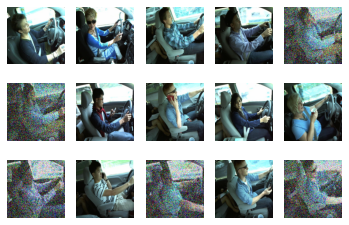

In [ ]:
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    #print (image)
    # place the colour channel at the end, instead of at the beginning
    image[0] = image[0] * mean[0] + std[0]
    image[1] = image[1] * mean[1] + std[1]
    image[2] = image[2] * mean[2] + std[2]
    
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

# AlexNet Pre Trained Features

In [7]:
# Save Features to Folder (assumes code from 1. has been evaluated)

import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# location on Google Drive
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features'

# Prepare Dataloader (requires code from 1.)
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
train_loader, val_loader, test_loader = get_data_loader()

classes = ['1. No Priority', '2. Low Priority', '3. Med Priority', '4. High Priority']

# save features to folder as tensors
def save_features_folder(data_loader):
  n = 0
  for img, label in data_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = master_path + '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
'''
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Train_Features'
save_features_folder(train_loader)
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Val_Features'
save_features_folder(val_loader)
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Test_Features'
save_features_folder(test_loader)
'''


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


"\nmaster_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Train_Features'\nsave_features_folder(train_loader)\nmaster_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Val_Features'\nsave_features_folder(val_loader)\nmaster_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Test_Features'\nsave_features_folder(test_loader)\n"

In [ ]:
import os
import torchvision.models
alexnet = torchvision.models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [10]:
# Load Tensor Files (features) from folder

#load features
# location on Google Drive
def load_features(batch_size = 32):
  dataset = torchvision.datasets.DatasetFolder(master_path, loader=torch.load, extensions=('.tensor'))

  # Prepare Dataloader
  num_workers = 1
  feature_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  # Verification Step - obtain one batch of features
  dataiter = iter(feature_loader)
  features, labels = dataiter.next()
  print(features.shape)
  print(labels.shape)

  return feature_loader
'''
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Train_Features'
feature_train = load_features()

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Val_Features'
feature_val = load_features()

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Test_Features'
feature_test = load_features()
'''

"\nmaster_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Train_Features'\nfeature_train = load_features()\n\nmaster_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Val_Features'\nfeature_val = load_features()\n\nmaster_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Test_Features'\nfeature_test = load_features()\n"

# GoogLeNet Pre Trained Features

In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)

import os

from googlenet_pytorch import GoogLeNet 
googLeNet = GoogLeNet.from_pretrained('googlenet')

# location on Google Drive
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet'

# Prepare Dataloader (requires code from 1.)
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
train_loader, val_loader, test_loader = get_data_loader()

classes = ['1. No Priority', '2. Low Priority', '3. Med Priority', '4. High Priority']

# save features to folder as tensors
def save_features_folder(data_loader):
  n = 0
  for img, label in data_loader:
      
    features = googLeNet.extract_features(img)

    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = master_path + '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
      
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

'''master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Train_Features'
save_features_folder(train_loader)
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Val_Features'
save_features_folder(val_loader)
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Test_Features'
save_features_folder(test_loader)'''

ModuleNotFoundError: ignored

In [ ]:
# Load Tensor Files (features) from folder

#load features
# location on Google Drive
def load_features(batch_size = 32):
  dataset = torchvision.datasets.DatasetFolder(master_path, loader=torch.load, extensions=('.tensor'))

  # Prepare Dataloader
  num_workers = 1
  feature_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  # Verification Step - obtain one batch of features
  dataiter = iter(feature_loader)
  features, labels = dataiter.next()
  print(features.shape)
  print(labels.shape)

  return feature_loader

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Train_Features'
feature_train = load_features()

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Val_Features'
feature_val = load_features()

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Test_Features'
feature_test = load_features()

torch.Size([32, 1024, 7, 7])
torch.Size([32])
torch.Size([32, 1024, 7, 7])
torch.Size([32])
torch.Size([32, 1024, 7, 7])
torch.Size([32])


# Model

In [5]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path_re = "/content/drive/MyDrive/APS 360 - Team 34/model_results/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path_re

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        predic = outputs.max(1, keepdim=True)[1]
        corr   = predic.eq(labels.view_as(predic))
        total_err += len(labels) - corr.sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)
    err = (float(total_err) / total_epoch)
    loss = float(total_loss) / (i + 1)
    return err, loss

def test_evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    predictions = []
    y = []
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        predic = outputs.max(1, keepdim=True)[1]

        predictions += predic.tolist()
        y += labels.tolist()

        corr   = predic.eq(labels.view_as(predic))
        total_err += len(labels) - corr.sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)
    err = (float(total_err) / total_epoch)
    loss = float(total_loss) / (i + 1)
    return err, loss, predictions, y

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    if overfit == False:
      plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    if overfit == False:
      plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [6]:
class TrasfLearnNet(nn.Module):
    def __init__(self, fc_no_layer = 1, hidden_units1 = 12, hidden_units2 = 5, kernel_size = 3, out_channel1 = 3, name = "AlexNet"):
        super(TrasfLearnNet, self).__init__()
        self.name = name
        self.conv1 = nn.Conv2d(256, out_channel1, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.hidden_units1 = hidden_units1
        self.hidden_units2 = hidden_units2
        self.kernel_size = kernel_size
        self.out_channel1 = out_channel1
        self.fc_no_layer = fc_no_layer
        if fc_no_layer == 1:
            self.fc1 = nn.Linear(hidden_units1, 4)
        elif fc_no_layer == 2:
            self.fc1 = nn.Linear(hidden_units1, hidden_units2)
            self.fc2 = nn.Linear(hidden_units2, 4)
        elif fc_no_layer == 10:
            hidden_units = np.random.randint(2,5, size=10)
            print(hidden_units)
            self.fc1 = nn.Linear(hidden_units1, 2**hidden_units[2])
            self.fc2 = nn.Linear(2**hidden_units[2], 2**hidden_units[3])
            self.fc3 = nn.Linear(2**hidden_units[3], 2**hidden_units[4])
            self.fc4 = nn.Linear(2**hidden_units[4], 2**hidden_units[5])
            self.fc5 = nn.Linear(2**hidden_units[5], 2**hidden_units[6])
            self.fc6 = nn.Linear(2**hidden_units[6], 2**hidden_units[7])
            self.fc7 = nn.Linear(2**hidden_units[7], 2**hidden_units[8])
            self.fc8 = nn.Linear(2**hidden_units[8], 2**hidden_units[9])
            self.fc9 = nn.Linear(2**hidden_units[9], 2**hidden_units[1])
            self.fc10 = nn.Linear(2**hidden_units[1], 4)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, self.hidden_units1)

        if self.fc_no_layer == 1:
            x = self.fc1(x)
        elif self.fc_no_layer == 2:
            x = self.fc1(x)
            x = self.fc2(F.relu(x))
        elif self.fc_no_layer == 10:
            x = self.fc1(x)
            x = self.fc2(F.relu(x))
            x = self.fc3(F.relu(x))
            x = self.fc4(F.relu(x))
            x = self.fc5(F.relu(x))
            x = self.fc6(F.relu(x))
            x = self.fc7(F.relu(x))
            x = self.fc8(F.relu(x))
            x = self.fc9(F.relu(x))
            x = self.fc10(F.relu(x))
        return x

In [ ]:
def train_net(net, batch_size=1, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets

    train_loader, val_loader, test_loader = feature_train, feature_val, feature_test
  
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy Loss.
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            #labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            #print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            predic = outputs.max(1, keepdim=True)[1]
            corr = predic.eq(labels.view_as(predic))
            total_train_err += len(labels) - corr.sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = (torch.true_divide(float(total_train_err), total_epoch))
        train_loss[epoch] = torch.true_divide(float(total_train_loss), (i+1))
        
        if overfit == False:
            val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        '''print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))'''
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    '''
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
        outputs = net(inputs)'''

    print('Finished Training')


    if overfit == False:
      print(("Minimum Val Error Epoch: {}, Minimum Val loss Epoch: {}|"+
              "Validation err: {}, Validation loss: {}|"+
            "Training Error: {}, Training loss: {}").format(
                  np.argmin(val_err),
                  np.argmin(val_loss),
                  min(val_err),
                  min(val_loss),
                  train_err[np.argmin(val_err)],
                  train_loss[np.argmin(val_loss)]))

    print(("Validation err: {}, Validation loss: {}|"+
           "Training Error: {}, Training loss: {}").format(
                val_err[num_epochs-1],
                val_loss[num_epochs-1],
                train_err[num_epochs-1],
                train_loss[num_epochs-1]))
    
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

# Alexnet Training

In [ ]:
isAlexNet = True
use_cuda = True
overfit = False
output = TrasfLearnNet()
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=32, learning_rate=0.001, num_epochs=50)

Finished Training
Minimum Val Error Epoch: 13, Minimum Val loss Epoch: 7|Validation err: 0.1927891837756635, Validation loss: 0.5449959550585065|Training Error: 0.11138767749071121, Training loss: 0.3994997441768646
Validation err: 0.20380570856284427, Validation loss: 0.8309674908717474|Training Error: 0.053640324622392654, Training loss: 0.16510595381259918


/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch49


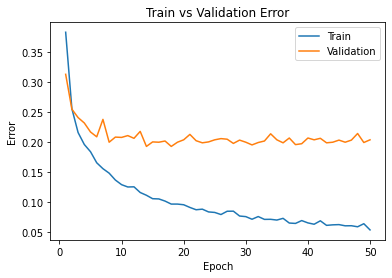

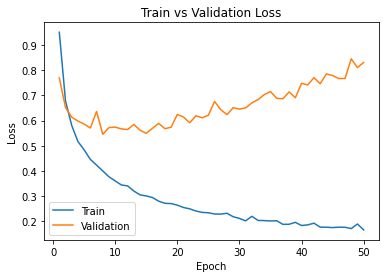

In [ ]:
model_path = get_model_name(output.name, batch_size=32, learning_rate=0.001, epoch=49)
print(model_path)
plot_training_curve(model_path)

In [ ]:
isAlexNet = True
use_cuda = True
overfit = True
output = TrasfLearnNet()
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=2, learning_rate=0.001, num_epochs=50)

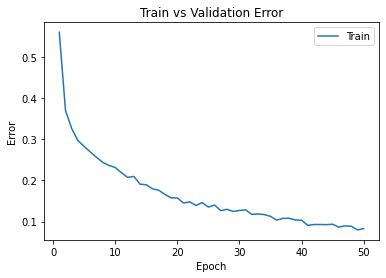

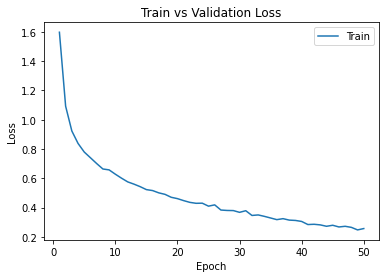

In [ ]:
model_path = get_model_name(output.name, batch_size=2, learning_rate=0.001, epoch=49)
plot_training_curve(model_path)

In [ ]:
isAlexNet = True
use_cuda = True
overfit = True
output = TrasfLearnNet()
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=2, learning_rate=0.001, num_epochs=100)

Finished Training
Validation err: 0.0, Validation loss: 0.0|Training Error: 0.01315789483487606, Training loss: 0.06602846831083298


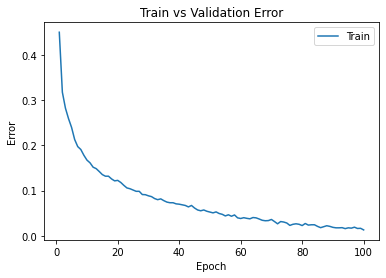

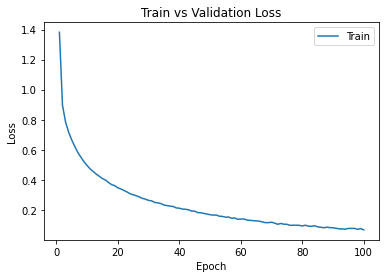

In [ ]:
model_path = get_model_name(output.name, batch_size=2, learning_rate=0.001, epoch=99)
plot_training_curve(model_path)

In [ ]:
isAlexNet = True
use_cuda = True
overfit = False
output = TrasfLearnNet()
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=2, learning_rate=0.001, num_epochs=100)

Finished Training
Minimum Val Error Epoch: 20, Minimum Val loss Epoch: 14|Validation err: 0.20738636363636365, Validation loss: 0.6275310733101584|Training Error: 0.09992887824773788, Training loss: 0.400957852602005
Validation err: 0.24147727272727273, Validation loss: 1.5879411778666757|Training Error: 0.012446656823158264, Training loss: 0.05943344533443451


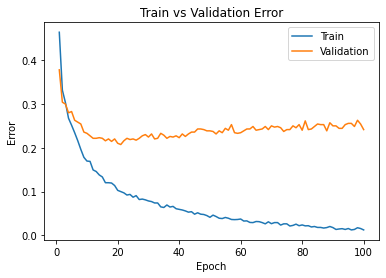

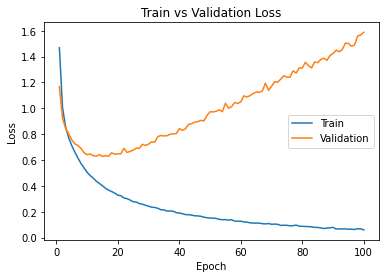

In [ ]:
model_path = get_model_name(output.name, batch_size=2, learning_rate=0.001, epoch=99)
plot_training_curve(model_path)

In [ ]:
isAlexNet = True
use_cuda = True
overfit = False
output = TrasfLearnNet(name = "Initial_add_noise")
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=2, learning_rate=0.001, num_epochs=30)

Finished Training
Minimum Val Error Epoch: 11, Minimum Val loss Epoch: 9|Validation err: 0.1690340909090909, Validation loss: 0.5157111192291434|Training Error: 0.0810810774564743, Training loss: 0.28586262464523315
Validation err: 0.1846590909090909, Validation loss: 0.7110052633691918|Training Error: 0.009601706638932228, Training loss: 0.06507275253534317


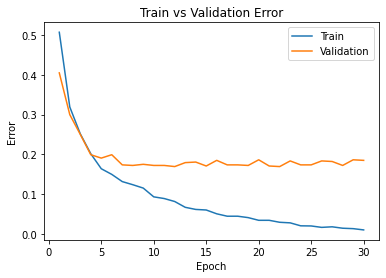

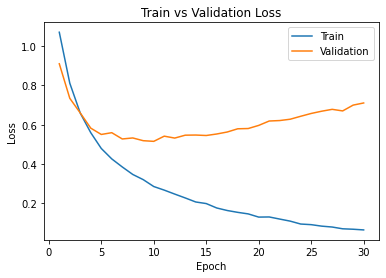

In [ ]:
model_path = get_model_name("Initial_add_noise", batch_size=2, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

# GoogLeNet Training

In [ ]:
batch_size = 16
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Train_Features'
feature_train = load_features(batch_size=batch_size)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Val_Features'
feature_val = load_features(batch_size=batch_size)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Test_Features'
feature_test = load_features(batch_size=batch_size)

use_cuda = True
overfit = False
input_size = 1024  * 7* 7
name = "Base_GoogleNet_1layer"
output = TrasfLearnNet(name = name, hidden_units1 = input_size, fc_no_layer=10)
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=16, learning_rate=0.001, num_epochs=30)

torch.Size([16, 1024, 7, 7])
torch.Size([16])
torch.Size([16, 1024, 7, 7])
torch.Size([16])
torch.Size([16, 1024, 7, 7])
torch.Size([16])
[3 4 4 3 3 3 3 2 3 3]
tensor([[-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456],
        [-0.6358, -0.7707,  0.3377,  0.6456]], device='cuda:0',
       grad_fn=<AddmmBackward>)


ZeroDivisionError: ignored

In [ ]:
@torch.no_grad() 
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix



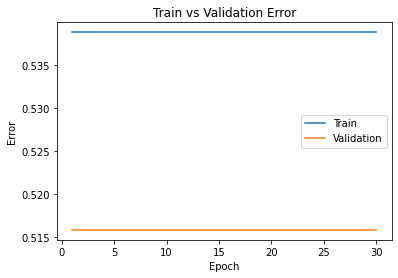

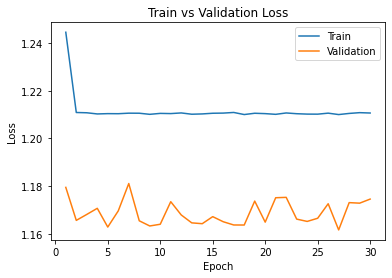

In [ ]:
model_path = get_model_name(name, batch_size=16, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

In [ ]:
batch_size = 16
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Train_Features'
feature_train = load_features(batch_size=batch_size)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Val_Features'
feature_val = load_features(batch_size=batch_size)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/GoogLeNet/Test_Features'
feature_test = load_features(batch_size=batch_size)

use_cuda = True
overfit = False
input_size = 1024  * 7* 7
name = "Base_GoogleNet_1layer"
output = TrasfLearnNet(name = name, hidden_units1 = input_size, fc_no_layer=10)
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=16, learning_rate=0.001, num_epochs=30)

torch.Size([16, 1024, 7, 7])
torch.Size([16])
torch.Size([16, 1024, 7, 7])
torch.Size([16])
torch.Size([16, 1024, 7, 7])
torch.Size([16])
[0 2 4 2 2 3 0 3 4 4]
Finished Training
Minimum Val Error Epoch: 0, Minimum Val loss Epoch: 26|Validation err: 0.515817223198594, Validation loss: 1.1628868927558262|Training Error: 0.863619863986969, Training loss: 1.2098582983016968
Validation err: 0.515817223198594, Validation loss: 1.1734751380152173|Training Error: 0.5388103127479553, Training loss: 1.2103381156921387


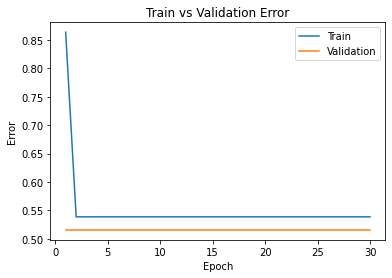

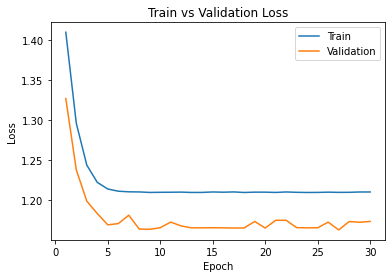

In [ ]:
model_path = get_model_name(name, batch_size=16, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

# Baseline Model: SVM

In [ ]:
train_loader, val_loader, test_loader = get_data_loader()

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

2812
704
19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

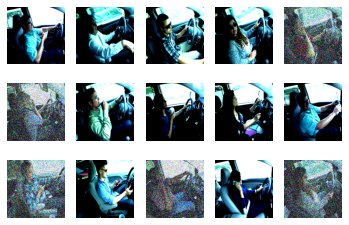

In [ ]:
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [ ]:
training_data = []
training_labels = []
i=0
noise = 0.5

for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    
    training_data.append((images[0].detach().numpy().flatten()))
    labelnp = labels[0]
    training_labels.append(labelnp.item())
    # Adding Noise 
    img_noisy = images + noise * torch.randn(*images.shape)
    img_noisy = np.clip(img_noisy, 0., 1.)
    training_data.append((img_noisy[0].detach().numpy().flatten()))
    training_labels.append(labelnp.item())
    i+=1



In [ ]:
i=0
testing_data = []
testing_labels = []
noise = 0.5

for images, labels in test_loader:
    # since batch_size = 1, there is only 1 image in `images`
    testing_data.append(images[0].detach().numpy().flatten())

    labelnp = labels[0]
    testing_labels.append(labelnp.item())
    #add noise
    '''img_noisy = images + noise * torch.randn(*images.shape)
    img_noisy = np.clip(img_noisy, 0., 1.)
    training_data.append((img_noisy[0].detach().numpy().flatten()))
    testing_labels.append(labelnp.item())'''

    i+=1


In [ ]:
#print(testing_data[0].shape)
print(training_labels[0].shape)
print(training_data)
print(training_labels)

In [ ]:
from sklearn import svm
model = svm.SVC(gamma=2, C=1)

#train_loader, val_loader, test_loader = get_data_loader():

# Fit the model to our training data
model.fit(training_data, training_labels)

# Make predictions
testing_predicted = model.predict(testing_data)
score = 100*(1-sum(abs(testing_predicted-testing_labels))/len(testing_predicted))
print("SVM Test:", score)

SVM Test: 21.765209940017137


In [ ]:
training_predicted = model.predict(training_data)
score_train = 100*(1-sum(abs(training_predicted-training_labels))/len(training_predicted))
print("SVM Train:", score_train)

SVM Train: 99.67994310099573


In [ ]:
from sklearn import svm
model = svm.SVC(gamma=2, C=1)

#train_loader, val_loader, test_loader = get_data_loader():

# Fit the model to our training data
model.fit(training_data, training_labels)

# Make predictions
testing_predicted = model.predict(testing_data)
score = 100*(1-sum(abs(testing_predicted-testing_labels))/len(testing_predicted))
print("SVM Test:", score)

In [ ]:
training_predicted = model.predict(training_data)
score_train = 100*(1-sum(abs(training_predicted-training_labels))/len(training_predicted))
print("SVM Train:", score_train)

# Confusion Matrix




In [ ]:
from sklearn.metrics import confusion_matrix

#feature_test = load_features()
model = TrasfLearnNet()
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch16'
#get_model_name("Initial_add_noise", batch_size=2, learning_rate=0.001, epoch=10)
state = torch.load(model_path)
model.load_state_dict(state)
use_cuda = True
err, loss, predictions, y = test_evaluate(model, feature_test, nn.CrossEntropyLoss())

print("error:", err)
print("loss:", loss)

error: 0.09943995021779714
loss: 0.2765242612905919


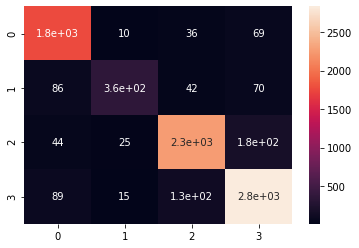

In [ ]:
import seaborn as sns

cf_matrix = confusion_matrix(y, predictions)
sns.heatmap(cf_matrix, annot=True)

#c0 Accuracy (Safe Driving)


In [152]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Training Dataset'
test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/state-farm-distracted-driver-detection/train_original/Individual Class Tests/c0'

In [150]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [153]:
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
train_loader, val_loader, test_loader = get_data_loader(mean=mean, std=std)

In [154]:
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/c0'
save_features_folder(test_loader)

In [ ]:
from sklearn.metrics import confusion_matrix

feature_test = load_features()

model = TrasfLearnNet()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch49'
state = torch.load(model_path)
model.load_state_dict(state)
use_cuda = True
err1, loss1, predictions1, y1 = test_evaluate(model, feature_test, nn.CrossEntropyLoss())


In [ ]:
import seaborn as sns

cf_matrix = confusion_matrix(y1, predictions1)
sns.heatmap(cf_matrix, annot=True)

#c1 c2 c3 c4 Accuracy (Phone)

In [111]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Training Dataset'
test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/state-farm-distracted-driver-detection/train_original/Individual Class Tests/c1,2,3,4'

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
train_loader, val_loader, test_loader = get_data_loader(mean=mean, std=std)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/c2'
save_features_folder(test_loader)

Mounted at /content/drive


In [112]:
from sklearn.metrics import confusion_matrix

feature_test = load_features()

model = TrasfLearnNet()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch17'
state = torch.load(model_path)
model.load_state_dict(state)
use_cuda = True
err1, loss1, predictions1, y1 = test_evaluate(model, feature_test, nn.CrossEntropyLoss())
print(predictions1)

torch.Size([32, 256, 6, 6])
torch.Size([32])
[[3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [2], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [2], [3], [3], [3], [3], [3], [3], [3], [3], [2], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [2], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3]]


error: 0.028368794326241134
loss: 0.13897003531455993
[[  0   0]
 [  4 137]]


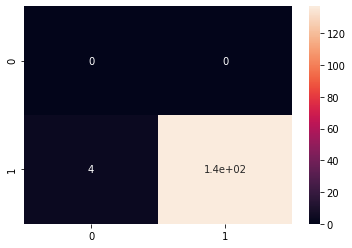

In [113]:
import seaborn as sns

cf_matrix = confusion_matrix(y1, predictions1)
sns.heatmap(cf_matrix, annot=True)

#c5 Accuracy (Radio)


In [130]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Training Dataset'
test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/state-farm-distracted-driver-detection/train_original/Individual Class Tests/c5'

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
train_loader, val_loader, test_loader = get_data_loader(mean=mean, std=std)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/c5'
save_features_folder(test_loader)

Mounted at /content/drive


In [131]:
from sklearn.metrics import confusion_matrix

feature_test = load_features()

model = TrasfLearnNet()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch49'
state = torch.load(model_path)
model.load_state_dict(state)
use_cuda = True
err1, loss1, predictions1, y1 = test_evaluate(model, feature_test, nn.CrossEntropyLoss())
print(predictions1)

torch.Size([32, 256, 6, 6])
torch.Size([32])
[[2], [2], [3], [2], [3], [2], [2], [2], [3], [2], [2], [3], [3], [1], [2], [3], [3], [1], [2], [3], [2], [2], [2], [2], [3], [1], [3], [3], [1], [1], [2], [3], [2], [2], [2], [2], [3], [2], [1], [2], [3], [3], [0], [3], [1], [2], [2], [3]]


error: 0.5208333333333334
loss: 3.4692347049713135
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 1  7 23 17]
 [ 0  0  0  0]]


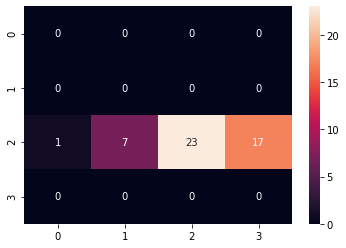

In [132]:
import seaborn as sns

cf_matrix = confusion_matrix(y1, predictions1)
sns.heatmap(cf_matrix, annot=True)

#c6 Accuracy (Drinking)

In [115]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Training Dataset'
test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/state-farm-distracted-driver-detection/train_original/Individual Class Tests/c6'

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
train_loader, val_loader, test_loader = get_data_loader(mean=mean, std=std)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/c6'
save_features_folder(test_loader)

Mounted at /content/drive


In [120]:
from sklearn.metrics import confusion_matrix

feature_test = load_features()

model = TrasfLearnNet()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch16'
state = torch.load(model_path)
model.load_state_dict(state)
use_cuda = True
err1, loss1, predictions1, y1 = test_evaluate(model, feature_test, nn.CrossEntropyLoss())
print(predictions1)

torch.Size([32, 256, 6, 6])
torch.Size([32])
[[1], [2], [3], [3], [1], [2], [3], [3], [2], [3], [3], [2], [2], [3], [3], [3], [3], [2], [3], [3], [3], [3], [2], [3], [3], [1], [1], [2], [1], [2], [2], [3], [3], [2], [3], [2], [2], [3], [3], [2], [3], [1], [3], [2], [2], [2], [2]]


error: 0.6170212765957447
loss: 4.3373329639434814
[[ 0  0  0]
 [ 6 18 23]
 [ 0  0  0]]


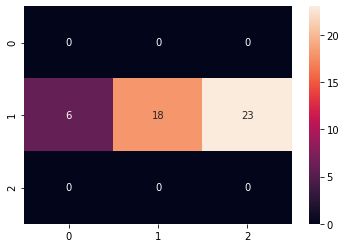

In [121]:
import seaborn as sns

cf_matrix = confusion_matrix(y1, predictions1)
sns.heatmap(cf_matrix, annot=True)

#c7 Accuracy (Reaching Back)

In [122]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Training Dataset'
test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/state-farm-distracted-driver-detection/train_original/Individual Class Tests/c7'

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
train_loader, val_loader, test_loader = get_data_loader(mean=mean, std=std)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/c7'
save_features_folder(test_loader)

Mounted at /content/drive


In [128]:
from sklearn.metrics import confusion_matrix

feature_test = load_features()

model = TrasfLearnNet()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch16'
state = torch.load(model_path)
model.load_state_dict(state)
use_cuda = True
err1, loss1, predictions1, y1 = test_evaluate(model, feature_test, nn.CrossEntropyLoss())
print(predictions1)

torch.Size([32, 256, 6, 6])
torch.Size([32])
[[1], [3], [3], [2], [2], [3], [3], [3], [2], [1], [3], [3], [2], [3], [1], [3], [3], [0], [3], [1], [2], [3], [3], [3], [3], [2], [2], [0], [1], [2], [1], [3], [3]]


error: 0.48484848484848486
loss: 1.814541041850589
[[0 0 0 0]
 [0 0 0 0]
 [2 3 8 8]
 [0 3 0 9]]


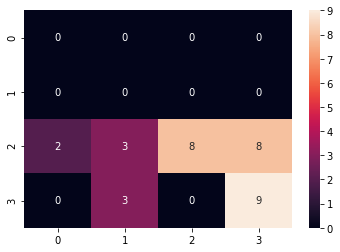

In [129]:
import seaborn as sns

cf_matrix = confusion_matrix(y1, predictions1)
sns.heatmap(cf_matrix, annot=True)

#c8 Accuracy (Hair and Makeup)


In [107]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Training Dataset'
test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/state-farm-distracted-driver-detection/train_original/Individual Class Tests/c8'

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
train_loader, val_loader, test_loader = get_data_loader(mean=mean, std=std)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/c3'
save_features_folder(test_loader)

Mounted at /content/drive


In [108]:
from sklearn.metrics import confusion_matrix

feature_test = load_features()

model = TrasfLearnNet()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch17'
state = torch.load(model_path)
model.load_state_dict(state)
use_cuda = True
err1, loss1, predictions1, y1 = test_evaluate(model, feature_test, nn.CrossEntropyLoss())
print(predictions1)

torch.Size([32, 256, 6, 6])
torch.Size([32])
[[3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [1], [3], [1], [3], [3], [3], [3], [3], [3], [3], [1], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [0], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3]]


error: 0.0851063829787234
loss: 0.3044396787881851
[[ 0  0  0]
 [ 0  0  0]
 [ 1  3 43]]


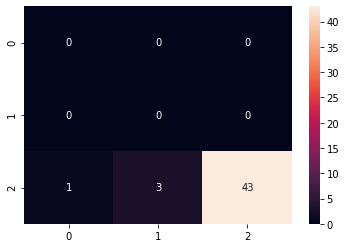

In [109]:
import seaborn as sns

cf_matrix = confusion_matrix(y1, predictions1)
sns.heatmap(cf_matrix, annot=True)

#Testing Accuracy


In [14]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Training Dataset'
test_path = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/Testing Dataset'

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
train_loader, val_loader, test_loader = get_data_loader(mean=mean, std=std)

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Test_Features'
save_features_folder(test_loader)

Mounted at /content/drive


In [15]:
from sklearn.metrics import confusion_matrix

feature_test = load_features()

model = TrasfLearnNet()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model = model.cuda()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch17'
state = torch.load(model_path)
model.load_state_dict(state)
use_cuda = True
err1, loss1, predictions1, y1 = test_evaluate(model, feature_test, nn.CrossEntropyLoss())
print(predictions1)

torch.Size([32, 256, 6, 6])
torch.Size([32])


EOFError: ignored

In [ ]:
import seaborn as sns

cf_matrix = confusion_matrix(y1, predictions1)
sns.heatmap(cf_matrix, annot=True)

# Hard Coding


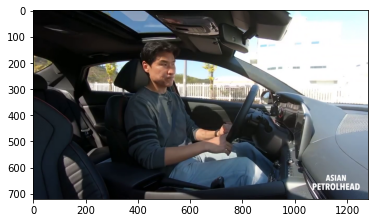

distracted at time  81.5  sec
[tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[2]]), tensor([[3]]), tensor([[3]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[0]]), tensor([[0]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[0]]), tensor([[3]]), tensor([[3]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[0]]), tensor([[2]]), tensor([[3]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[2]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[

In [ ]:
#from alexnet_pytorch import AlexNet
#Alex_Net = AlexNet.from_pretrained('alexnet')
from PIL import Image
from IPython.display import clear_output
import time
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

model = TrasfLearnNet()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch13'
state = torch.load(model_path)
model.load_state_dict(state)

# Program To Read video and Extract Frames 
import cv2 

# Function to extract frames 
def FrameCapture(path, frame_per_sec, med_depth, low_depth): 
    
    # get video file 
    vidObj = cv2.VideoCapture(path) 
  
    # Used as counter variable 
    count = 0
    frame_count = 0
  
    # checks whether frames were extracted 
    success = True

    #list to store past outputs
    outputs = []

    #loop through frames
    while success: 
  
        # vidObj object calls read 
        # function extract frames (every 12 frames used since assuming 24 frames/sec)
        for i in range(int(frame_per_sec/2)):
            success, image = vidObj.read()
            if not success:
                return outputs 
            frame_count += 1

        # clear previous image, display image
        time.sleep(1)
        clear_output()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        cv2.waitKey(0)
        plt.show()

        #preprocess images to run through alexnet
        transform = transforms.Compose(
        [transforms.Resize((224, 224)),
        transforms.ToTensor(),
         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

        image = Image.fromarray(image) #covert to PIL image
        image = transform(image) #apply transforms
        #print(image)

        image = image.unsqueeze(0)
        features = alexnet.features(image)
        #features = alexnet.features(image)
        preds = model(features) #4 elemt list
        #print(preds)
        output = preds.max(1, keepdim=True)[1]
        #print(output)
            
        #high priority
        if output == 3:
            print('distracted at time ', count/2 + 1, ' sec')
            
        #med priority
        elif output + sum(outputs[(frame_count - med_depth):]) > 10:
            print('distracted at time ', count/2 + 1, ' sec')

        #low priority
        elif output + sum(outputs[(frame_count - low_depth):]) > 4:
            print('Distracted at time ', count/2 + 1, ' sec')

        else:
            print("Not Distracted")

        count += 1
        outputs.append(output)

  
# Driver Code 
if __name__ == '__main__': 
    
    #path to video
    PATH2vid = '/content/drive/MyDrive/APS 360 - Team 34/Test Clips/APS360 Test Clip.mp4'

    #number of consecutive 0.5s to check for med and low priorities before flagging as distracted
    med_depth = 3 # 3*0.5 = 1.5 sec before distracted
    low_depth = 6 # 6*0.5 = 3 sec before distracted
    
    frame_per_sec = 24 #must be even

    # Calling the function 
    outputs = FrameCapture(PATH2vid, frame_per_sec, med_depth, low_depth)
    print(outputs)


In [ ]:
pip install colorama

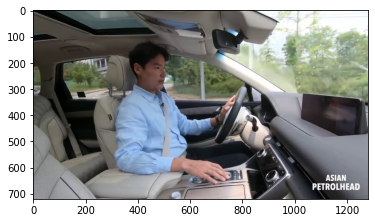

distracted at time  87.0  sec
[tensor([[1]]), tensor([[1]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[1]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[1]]), tensor([[1]]), tensor([[1]]), tensor([[1]]), tensor([[3]]), tensor([[3]]), tensor([[3]]), tensor([[1]]), tensor([[3]]), tensor([[

In [ ]:
#from alexnet_pytorch import AlexNet
#Alex_Net = AlexNet.from_pretrained('alexnet')
from PIL import Image
from IPython.display import clear_output
from colorama import Fore
import time
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

model = TrasfLearnNet()
model_path = '/content/drive/MyDrive/APS 360 - Team 34/model_results/model_AlexNet_bs32_lr0.001_epoch13'
state = torch.load(model_path)
model.load_state_dict(state)

# Program To Read video and Extract Frames 
import cv2 

# Function to extract frames 
def FrameCapture(path, frame_per_sec, med_depth, low_depth): 
    
    # get video file 
    vidObj = cv2.VideoCapture(path) 
  
    # Used as counter variable 
    count = 0
    frame_count = 0
  
    # checks whether frames were extracted 
    success = True

    #list to store past outputs
    outputs = []

    #loop through frames
    while success: 
  
        # vidObj object calls read 
        # function extract frames (every 12 frames used since assuming 24 frames/sec)
        for i in range(int(frame_per_sec/2)):
            success, image = vidObj.read()
            if not success:
                return outputs 
            frame_count += 1

        # clear previous image, display image
        time.sleep(1)
        clear_output()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        cv2.waitKey(0)
        plt.show()

        #preprocess images to run through alexnet
        transform = transforms.Compose(
        [transforms.Resize((224, 224)),
        transforms.ToTensor(),
         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

        image = Image.fromarray(image) #covert to PIL image
        image = transform(image) #apply transforms
        #print(image)

        image = image.unsqueeze(0)
        features = alexnet.features(image)
        #features = alexnet.features(image)
        preds = model(features) #4 elemt list
        #print(preds)
        output = preds.max(1, keepdim=True)[1]
        #print(output)
            
        #high priority
        if output == 3:
            print(Fore.RED + 'distracted at time ', count/2 + 1, ' sec')
            
        #med priority
        elif output + sum(outputs[(frame_count - med_depth):]) > 10:
            print(Fore.RED + 'distracted at time ', count/2 + 1, ' sec')

        #low priority
        elif output + sum(outputs[(frame_count - low_depth):]) > 4:
            print(Fore.RED + 'Distracted at time ', count/2 + 1, ' sec')

        else:
            print(Fore.GREEN + "Not Distracted")

        count += 1
        outputs.append(output)

  
# Driver Code 
if __name__ == '__main__': 
    
    #path to video
    PATH2vid = '/content/drive/MyDrive/APS 360 - Team 34/Test Clips/APS360 Test Clip 2.mp4'

    #number of consecutive 0.5s to check for med and low priorities before flagging as distracted
    med_depth = 3 # 3*0.5 = 1.5 sec before distracted
    low_depth = 6 # 6*0.5 = 3 sec before distracted
    
    frame_per_sec = 24 #must be even

    # Calling the function 
    outputs = FrameCapture(PATH2vid, frame_per_sec, med_depth, low_depth)
    print(outputs)
